# Pancancer Boxplot for PTEN trans effect on MCM4 phosphoproteomics

This notebook creates a boxplot for the trans effect of PTEN cnv deletions in 8 cancers. These 8 cancers were chosen because they have enough samples with PTEN cnv deletions to do a t-test. Only Ccrcc does not have enough samples with deletions. 

Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import gseapy as gp
import re
import sys 

import cptac
import cptac.utils as u

import sys
import plot_utils as ut

Functions:

format_df prepares a data frame with PTEN proteomics and PTEN mutation types from get_genotype_all_vars.

format_pval_annotation is used to add marks to the boxplot. A star represents significant p-value and "ns" represents a nonsignificant p-value.

In [2]:
# Returns a dataframe with proteomics and mutation type

def format_df(cancer_object, trans_gene, gene_in = 'PTEN', drop_level = 3):
    mut_type = cancer_object.get_genotype_all_vars(gene_in)
    
    if cancer_object.get_cancer_type() not in ('luad'):
        # Keep only tumor samples from proteomics
        prot_and_mutations = cancer_object.join_omics_to_mutations(
            mutations_genes = [gene_in], omics_df_name = 'phosphoproteomics', omics_genes = trans_gene)
        prot_and_mutations = prot_and_mutations[prot_and_mutations.Sample_Status == "Tumor"] # drop Normal samples
        
        # Reduce a multiindex 
        if isinstance(prot_and_mutations.keys(), pd.core.indexes.multi.MultiIndex):
            prot_and_mutations = cancer_object.reduce_multiindex(prot_and_mutations,
                                                                 levels_to_drop=[drop_level], flatten=True)

        # Merge Mutation column from get_genotype_all_vars (includes cnv) with proteomics
        mut_type = mut_type[['Mutation']] 
        prot_df = prot_and_mutations.iloc[:,:-4] # Keep only proteomics
        merged = prot_df.join(mut_type)
        
        # Keep only Wildtype and deletion
        compare = ['Wildtype_Tumor','Deletion']
        get = merged['Mutation'].isin(compare)
        del_wt = merged[get]
    
    
    # Luad has no somatic mutations for PTEN which changes some things
    else: 
        # get_genotype_all_vars add cnv data under the column PTEN
        mut_type = mut_type.drop(columns= gene_in)
        # different code because no somatic mutation data for pten (can't join to somatic mutations)
        omics = cancer_object.join_omics_to_omics(df1_name = 'CNV', df2_name='phosphoproteomics',genes1= gene_in, 
            genes2=trans_gene)
        omics = cancer_object.reduce_multiindex(omics, levels_to_drop = 1, flatten = True)
        omics = omics.drop(columns='PTEN_CNV__')
        # Get only tumor samples
        p = l.get_proteomics(tissue_type='tumor')
        tumor_ids = list(p.index)
        get = omics.index.isin(tumor_ids)
        omics = omics[get]
        # Merge Mutation column from get_genotype_all_vars (includes cnv) with proteomics
        merged = omics.join(mut_type) 
        # Keep only No_Mutation (wildtype) and deletion
        compare = ['No_Mutation','Deletion']
        get = merged['Mutation'].isin(compare)
        del_wt = merged[get]
        del_wt['Mutation'] = np.where(
            del_wt['Mutation'] == 'No_Mutation', 'Wildtype_Tumor', 'Deletion')

    return del_wt


In [3]:
def format_pval_annotation(pval_symbol, x1, x2, line_start = .05, line_height=.05):
    # for manual adjustment to pval annotations
    
    y, h = line_start, line_height
    plt.plot([x1, x1, x2, x2], #draw horizontal line
             [y, y+h, y+h, y], #vertical line
             lw=1.5, color= '.3')
    plt.text((x1+x2)*.5, # half between x coord
             y+h, pval_symbol, horizontalalignment='center', verticalalignment='bottom', color = "black")


# Step 1: Create data frames with PTEN cnv deletion and Proteomics

Each cancer needs a data frame containing only samples that have PTEN cnv deletions or PTEN wildtype tumors and PTEN proteomics.

First, load in cancer data sets from cptac. Note: Keep the variable names the same because they are used in format_df to reduce multiindexs found in certain cancer data sets. 

In [4]:
en = cptac.Endometrial()
h = cptac.Hnscc()
l = cptac.Luad()
ls = cptac.Lscc()
o = cptac.Ovarian()
g = cptac.Gbm()
b = cptac.Brca()
col = cptac.Colon()

cptac warning: The HNSCC data is currently strictly reserved for CPTAC investigators. Otherwise, you are not authorized to access these data. Additionally, even after these data become publicly available, they will be subject to a publication embargo (see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details). (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 2)


cptac warning: The LUAD dataset is under publication embargo until July 01, 2020. CPTAC is a community resource project and data are made available rapidly after generation for community research use. The embargo allows exploring and utilizing the data, but analysis may not be published until after the embargo date. Please see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details. (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 3)


cptac warning: The LSCC data is currently strictly reserved for CPTAC investigators. Otherwise, you are not authorized to access these data. Additionally, even after these data become publicly available, they will be subject to a publication embargo (see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details). (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 4)


cptac warning: The GBM dataset is under publication embargo until March 01, 2021. CPTAC is a community resource project and data are made available rapidly after generation for community research use. The embargo allows exploring and utilizing the data, but analysis may not be published until after the embargo date. Please see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details. (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 6)


Next, use format_df to create the specific data frame for each cancer. Use wrap_ttest to test PTEN deletion vs. wildtype. 

# Gbm

In [6]:
gene = 'PTEN'
t_gene = 'MCM4'
g_del_wt = format_df(g, t_gene)
g_del_wt.head()

cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 72 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\cptac\dataset.py, line 394)
cptac warning: CNV data was not found for the following samples, so CNV data columns were filled with NaN for these samples: C3L-01834 (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\cptac\dataset.py, line 394)
cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 82 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 9)


Name,MCM3_phosphoproteomics_S205_RYS*DLTTLVAFPSSSVYPTK,MCM3_phosphoproteomics_S713_KRS*EDESETEDEEEK,MCM3_phosphoproteomics_S713S717_KRS*EDES*ETEDEEEK,MCM3_phosphoproteomics_S713S717T719_KRS*EDES*ET*EDEEEK,MCM3_phosphoproteomics_S713T719_RS*EDESET*EDEEEK,MCM3_phosphoproteomics_S713T719S726_RS*EDESET*EDEEEKS*QEDQEQK,MCM3_phosphoproteomics_S717_KRSEDES*ETEDEEEK,MCM3_phosphoproteomics_S717_RSEDES*ETEDEEEK,MCM3_phosphoproteomics_S717T719_KRSEDES*ET*EDEEEK,MCM3_phosphoproteomics_S717T719_RSEDES*ET*EDEEEK,...,MCM3_phosphoproteomics_T719_RSEDESET*EDEEEK,MCM3_phosphoproteomics_T719S726_RSEDESET*EDEEEKS*QEDQEQK,MCM3_phosphoproteomics_T758_DGDSYDPYDFSDT*EEEMPQVHTPK,MCM3_phosphoproteomics_T758T767_DGDSYDPYDFSDT*EEEMPQVHT*PK,MCM3_phosphoproteomics_T767_DGDSYDPYDFSDTEEEMPQVHT*PK,MCM3_phosphoproteomics_Y750T758_DGDSY*DPYDFSDT*EEEMPQVHTPK,MCM3_phosphoproteomics_Y750T758T767_DGDSY*DPYDFSDT*EEEMPQVHT*PK,MCM3_phosphoproteomics_Y753S756_DGDSYDPY*DFS*DTEEEMPQVHTPK,MCM3_phosphoproteomics_Y753T758_DGDSYDPY*DFSDT*EEEMPQVHTPK,Mutation
Patient_ID,,,,,,,,,,,,,,,,,,,,,
C3L-00104,1.078313,1.197712,0.636480,1.140307,NaN,NaN,NaN,0.789201,0.609024,0.944351,...,1.059769,0.678117,0.404877,0.760381,1.263384,-0.027740,0.738357,NaN,NaN,Deletion
C3L-00365,0.868698,0.520708,0.746420,1.587860,NaN,NaN,0.339036,0.394290,NaN,0.922311,...,NaN,NaN,NaN,1.179724,NaN,1.487462,0.919016,NaN,NaN,Deletion
C3L-00674,0.281070,0.230958,-0.393435,-0.710630,-0.369789,NaN,NaN,-0.503656,NaN,-0.364562,...,NaN,NaN,-0.544556,NaN,0.523043,-0.490306,-0.500680,NaN,NaN,Deletion
C3L-00677,-0.312857,-0.403621,-0.416728,0.025458,NaN,1.676289,NaN,-0.611863,NaN,-0.022558,...,-0.428378,NaN,-0.870803,0.144140,-0.125183,NaN,0.060158,NaN,NaN,Deletion
C3L-01040,-0.478029,1.040704,-0.729764,-1.381473,NaN,NaN,NaN,-0.283311,-0.829937,-1.666821,...,-1.484511,-0.069588,-1.647757,-0.782928,-0.504335,-1.203474,-1.139279,NaN,NaN,Deletion


In [7]:
cols = list(g_del_wt.columns[:-1])

g_pval = u.wrap_ttest(g_del_wt, 'Mutation', cols)#, return_all = True)
gp = g_pval['P_Value']
g_pval

C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\numpy\core\fromnumeric.py:3367: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
C:\Users\brittany henderson\Anaconda3\e

,Comparison,P_Value
0,MCM3_phosphoproteomics_S717_RSEDES*ETEDEEEK,4.715054e-08
1,MCM3_phosphoproteomics_S713S717_KRS*EDES*ETEDEEEK,3.917191e-06
2,MCM3_phosphoproteomics_S713S717T719_KRS*EDES*E...,1.248490e-05
3,MCM3_phosphoproteomics_S756T758_DGDSYDPYDFS*DT...,2.452556e-05
4,MCM3_phosphoproteomics_T719_RSEDESET*EDEEEK,3.921622e-05
5,MCM3_phosphoproteomics_T758T767_DGDSYDPYDFSDT*...,4.333848e-04


# Luad

In [10]:
l_del_wt = format_df(l, t_gene, drop_level=4) # fix col name

# t-test
cols = list(l_del_wt.columns[:-1])
l_pval = u.wrap_ttest(l_del_wt, 'Mutation', cols)#, return_all = True)
#lp = l_pval['P_Value'][0]
l_pval

cptac warning: CNV data was not found for the following samples, so CNV data columns were filled with NaN for these samples: C3L-00001.N, C3L-00009.N, C3L-00080.N, C3L-00083.N, C3L-00093.N, C3L-00094.N, C3L-00095.N, C3L-00140.N, C3L-00144.N, C3L-00263.N, C3L-00279.N, C3L-00368.N, C3L-00412.N, C3L-00422.N, C3L-00510.N, C3L-00604.N, C3L-00893.N, C3L-00913.N, C3L-00973.N, C3L-01330.N, C3L-01632.N, C3L-01682.N, C3L-01683.N, C3L-01889.N, C3L-01890, C3L-01890.N, C3L-01924.N, C3L-02219.N, C3L-02345.N, C3L-02348.N, C3L-02350.N, C3L-02365.N, C3L-02508.N, C3L-02549.N, C3N-00167.N, C3N-00169.N, C3N-00175.N, C3N-00180.N, C3N-00199.N, C3N-00203.N, C3N-00217.N, C3N-00223.N, C3N-00293.N, C3N-00433.N, C3N-00546.N, C3N-00547.N, C3N-00549.N, C3N-00550.N, C3N-00551.N, C3N-00552.N, C3N-00556.N, C3N-00559.N, C3N-00560.N, C3N-00572.N, C3N-00574.N, C3N-00578.N, C3N-00579.N, C3N-00580.N, C3N-00704.N, C3N-00737.N, C3N-00738.N, C3N-00959.N, C3N-01016.N, C3N-01021.N, C3N-01023.N, C3N-01024.N, C3N-01030.N, C3N-01

# Lscc

In [11]:
ls_del_wt = format_df(ls, t_gene)

# t-test
cols = list(ls_del_wt.columns[:-1])
ls_pval = u.wrap_ttest(ls_del_wt, 'Mutation', cols)#, return_all = True)
ls_pval

cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 99 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\cptac\dataset.py, line 394)
cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 201 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 9)


,Comparison,P_Value
0,MCM3_phosphoproteomics_S717_SEDEsETEDEEEK,0.000059
1,MCM3_phosphoproteomics_S713_KRsEDESETEDEEEK,0.000131
2,MCM3_phosphoproteomics_S717T719_SEDEsEtEDEEEK,0.000558
3,MCM3_phosphoproteomics_S726_RSEDESETEDEEEKsQED...,0.000678
4,MCM3_phosphoproteomics_T719_RSEDESEtEDEEEK,0.001646
5,MCM3_phosphoproteomics_S756T758_DGDSYDPYDFsDtE...,0.001785
6,MCM3_phosphoproteomics_S749_DGDsYDPYDFSDTEEEMP...,0.002089
7,MCM3_phosphoproteomics_T767_DGDSYDPYDFSDTEEEMP...,0.002215


# Ovarian

In [12]:
o_del_wt = format_df(o, t_gene)

# t-test
cols = list(o_del_wt.columns[:-1])
o_pval = u.wrap_ttest(o_del_wt, 'Mutation', cols)#, return_all = True)
#op = o_pval['P_Value'][0]
o_pval

cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 98 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\cptac\dataset.py, line 394)
cptac warning: CNV data was not found for the following samples, so CNV data columns were filled with NaN for these samples: 01OV029, 02OV015 (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\cptac\dataset.py, line 394)
cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 99 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 9)
cptac warning: Due to dropping the specified levels, dataframe now has 36 duplicated column headers. (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-package

Incorrectly Formatted Dataframe!



C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\numpy\core\fromnumeric.py:3367: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\numpy\core\_methods.py:130: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


# Brca

In [13]:
b_del_wt = format_df(b, t_gene)

# t-test
cols = list(b_del_wt.columns[:-1])
b_pval = u.wrap_ttest(b_del_wt, 'Mutation', cols)#, return_all = True)
#bp = b_pval['P_Value'][0]
b_pval

cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 113 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\cptac\dataset.py, line 394)
cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 113 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 9)


# Colon

In [14]:
c_del_wt = format_df(col, t_gene, drop_level = 2)

# t-test
cols = list(c_del_wt.columns[:-1])
c_pval = u.wrap_ttest(c_del_wt, 'Mutation', cols)#, return_all = True)
#cp = c_pval['P_Value'][0]
c_pval

cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 100 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\cptac\dataset.py, line 394)
cptac warning: CNV data was not found for the following samples, so CNV data columns were filled with NaN for these samples: 05CO045 (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\cptac\dataset.py, line 394)
cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 201 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 9)
cptac warning: phosphoproteomics data was not found for the following samples, so phosphoproteomics data columns were filled with NaN for these samples: 01CO001, 05CO005, 05CO00

#  Hnscc

In [15]:
h_del_wt = format_df(h, t_gene, drop_level=3)

# t-test
cols = list(h_del_wt.columns[:-1])
h_pval = u.wrap_ttest(h_del_wt, 'Mutation', cols)
                      #, return_all = True)
#hp = h_pval['P_Value'][0]
h_pval

cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 109 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\cptac\dataset.py, line 394)
cptac warning: CNV data was not found for the following samples, so CNV data columns were filled with NaN for these samples: C3L-02617, C3N-02727 (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\cptac\dataset.py, line 394)
cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 176 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 9)


# Endometrial

The Endometrial data set does not have enough cnv deletions to perform a t-test, however the data set does have enough truncation type mutations (nonsense and frame shifts). Different code is needed to create the data frame for Endometrial.

In [16]:
# Step 1 - Create proteomics and truncations dataframe
prot_and_mutations = en.join_omics_to_mutations(
    mutations_genes = [gene], omics_df_name = 'phosphoproteomics', omics_genes = t_gene, 
    mutations_filter = ['Nonsense_Mutation','Frame_Shift_Del','Frame_Shift_Ins']) 
prot_and_mutations = en.reduce_multiindex(prot_and_mutations, flatten = True)
keep = ['Nonsense_Mutation','Frame_Shift_Del','Frame_Shift_Ins','Wildtype_Tumor']
in_keep = prot_and_mutations['PTEN_Mutation_'].isin(keep) 
trunc_mutations = prot_and_mutations[in_keep]
print(trunc_mutations['PTEN_Mutation_'].value_counts()) # may need to change extra char

# Step 2 - Create binary column 
trunc_mutations['Mutation'] = np.where(
            trunc_mutations[gene+'_Mutation_Status_'] == 'Wildtype_Tumor', 'Wildtype_Tumor', 'Truncation')

# Step 3 - Format the dataframe correctly for the t-test(just omics and binary columns for tumors)
tumors = trunc_mutations[trunc_mutations.Sample_Status_ == 'Tumor'] #drop Normal samples
columns_to_drop = [gene+"_Mutation_", gene+"_Location_", gene+"_Mutation_Status_", "Sample_Status_"]
e_trunc_wt = tumors.drop(columns_to_drop, axis = 1)
e_trunc_wt = e_trunc_wt.dropna(axis=1,how='all')
e_trunc_wt['Mutation'].value_counts()

# t-test
cols = list(e_trunc_wt.columns[:-1])
e_pval = u.wrap_ttest(e_trunc_wt, 'Mutation', cols)
#ep = e_pval['P_Value'][0]
e_pval

Nonsense_Mutation    25
Frame_Shift_Del      22
Wildtype_Tumor       20
Frame_Shift_Ins       6
Name: PTEN_Mutation_, dtype: int64


cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 69 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 4)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,Comparison,P_Value
0,MCM3_phosphoproteomics_S726,0.000394
1,MCM3_phosphoproteomics_T719,0.001555


# Step 2: Create a long dataframe for the boxplot

The boxplot will take three columns: Site, Omics, and Mutation. Only the significant phosphosites are appended from the individual cancer dfs into one long pancancer df. 

Keep significant phosphosites

In [83]:
g_sig = list(g_pval.Comparison)
g_df = g_del_wt.columns.isin(g_sig)
g_sig_df = g_del_wt[g_del_wt.columns[g_df]]

g_mut = g_del_wt[['Mutation']]
g_mut = g_mut['Mutation'].apply(lambda x: 'Gbm_Deletion' if x == 'Deletion' else 'Gbm_Wildtype_Tumor')
g_sig_df = g_sig_df.join(g_mut)

# rename cols
g_sig_df = g_sig_df.rename(columns=lambda x: re.sub('_phosphoproteomics','', x))
g_sig_df = g_sig_df.rename(columns=lambda x: re.sub('_[A-Z*]*$', '', x))

pgs = g_sig_df.melt(id_vars = ['Mutation'], var_name = 'Site', value_name = 'Omics')
pgs = pgs.assign(Cancer = 'Gbm')
pgs

,Mutation,Site,Omics,Cancer
0,Gbm_Deletion,MCM3_S713S717,0.636480,Gbm
1,Gbm_Deletion,MCM3_S713S717,0.746420,Gbm
2,Gbm_Deletion,MCM3_S713S717,-0.393435,Gbm
3,Gbm_Deletion,MCM3_S713S717,-0.416728,Gbm
4,Gbm_Deletion,MCM3_S713S717,-0.729764,Gbm
...,...,...,...,...
577,Gbm_Deletion,MCM3_T758T767,0.192255,Gbm
578,Gbm_Deletion,MCM3_T758T767,1.224494,Gbm
579,Gbm_Deletion,MCM3_T758T767,-0.765056,Gbm
580,Gbm_Wildtype_Tumor,MCM3_T758T767,-0.338715,Gbm


In [84]:
ls_sig = list(ls_pval.Comparison)
ls_df = ls_del_wt.columns.isin(ls_sig)
ls_sig_df = ls_del_wt[ls_del_wt.columns[ls_df]]

ls_mut = ls_del_wt[['Mutation']]
ls_mut = ls_mut['Mutation'].apply(lambda x: 'Lscc_Deletion' if x == 'Deletion' else 'Lscc_Wildtype_Tumor')
ls_sig_df = ls_sig_df.join(ls_mut)

# rename cols
ls_sig_df = ls_sig_df.rename(columns=lambda x: re.sub('_phosphoproteomics','', x))
ls_sig_df = ls_sig_df.rename(columns=lambda x: re.sub('_[st]?[A-Z]+[st]+[A-Z]*[st]*[A-Z]*$', '', x))

lss = ls_sig_df.melt(id_vars = ['Mutation'], var_name = 'Site', value_name = 'Omics')
lss = lss.assign(Cancer = 'Lscc')
lss
ls_sig_df

,MCM3_S713,MCM3_S717,MCM3_S717T719,MCM3_S726,MCM3_S749,MCM3_S756T758,MCM3_T719,MCM3_T767,Mutation
Patient_ID,,,,,,,,,
C3L-00081,0.6483,0.9986,0.9336,1.4874,NaN,0.5932,0.8852,NaN,Lscc_Deletion
C3L-00415,-7.2930,-0.4353,0.0226,-1.9110,-1.6303,0.1412,-0.3648,-3.5534,Lscc_Wildtype_Tumor
C3L-00445,2.2810,1.8534,1.2742,NaN,NaN,0.6623,1.6403,NaN,Lscc_Deletion
C3L-00568,NaN,1.5998,0.7909,NaN,2.0943,0.1661,2.2668,3.0890,Lscc_Wildtype_Tumor
C3L-00603,-0.5621,0.5618,0.9036,NaN,-0.2532,1.2711,1.1124,NaN,Lscc_Wildtype_Tumor
...,...,...,...,...,...,...,...,...,...
C3N-03886,NaN,2.4379,3.1722,0.2543,NaN,2.3347,3.4541,0.2027,Lscc_Deletion
C3N-04124,-1.9205,-1.5593,-0.8437,-1.7531,-2.1121,-0.8018,0.5216,-1.0771,Lscc_Wildtype_Tumor
C3N-04127,NaN,-1.8766,-0.4578,NaN,NaN,-0.1648,-1.4380,-1.4279,Lscc_Wildtype_Tumor


In [85]:
# Append
sig_phos = lss.append(pgs)
sig_phos

,Mutation,Site,Omics,Cancer
0,Lscc_Deletion,MCM3_S713,0.648300,Lscc
1,Lscc_Wildtype_Tumor,MCM3_S713,-7.293000,Lscc
2,Lscc_Deletion,MCM3_S713,2.281000,Lscc
3,Lscc_Wildtype_Tumor,MCM3_S713,NaN,Lscc
4,Lscc_Wildtype_Tumor,MCM3_S713,-0.562100,Lscc
...,...,...,...,...
577,Gbm_Deletion,MCM3_T758T767,0.192255,Gbm
578,Gbm_Deletion,MCM3_T758T767,1.224494,Gbm
579,Gbm_Deletion,MCM3_T758T767,-0.765056,Gbm
580,Gbm_Wildtype_Tumor,MCM3_T758T767,-0.338715,Gbm


Next append the dfs.

# Step 3: Create the Pancancer Boxplot

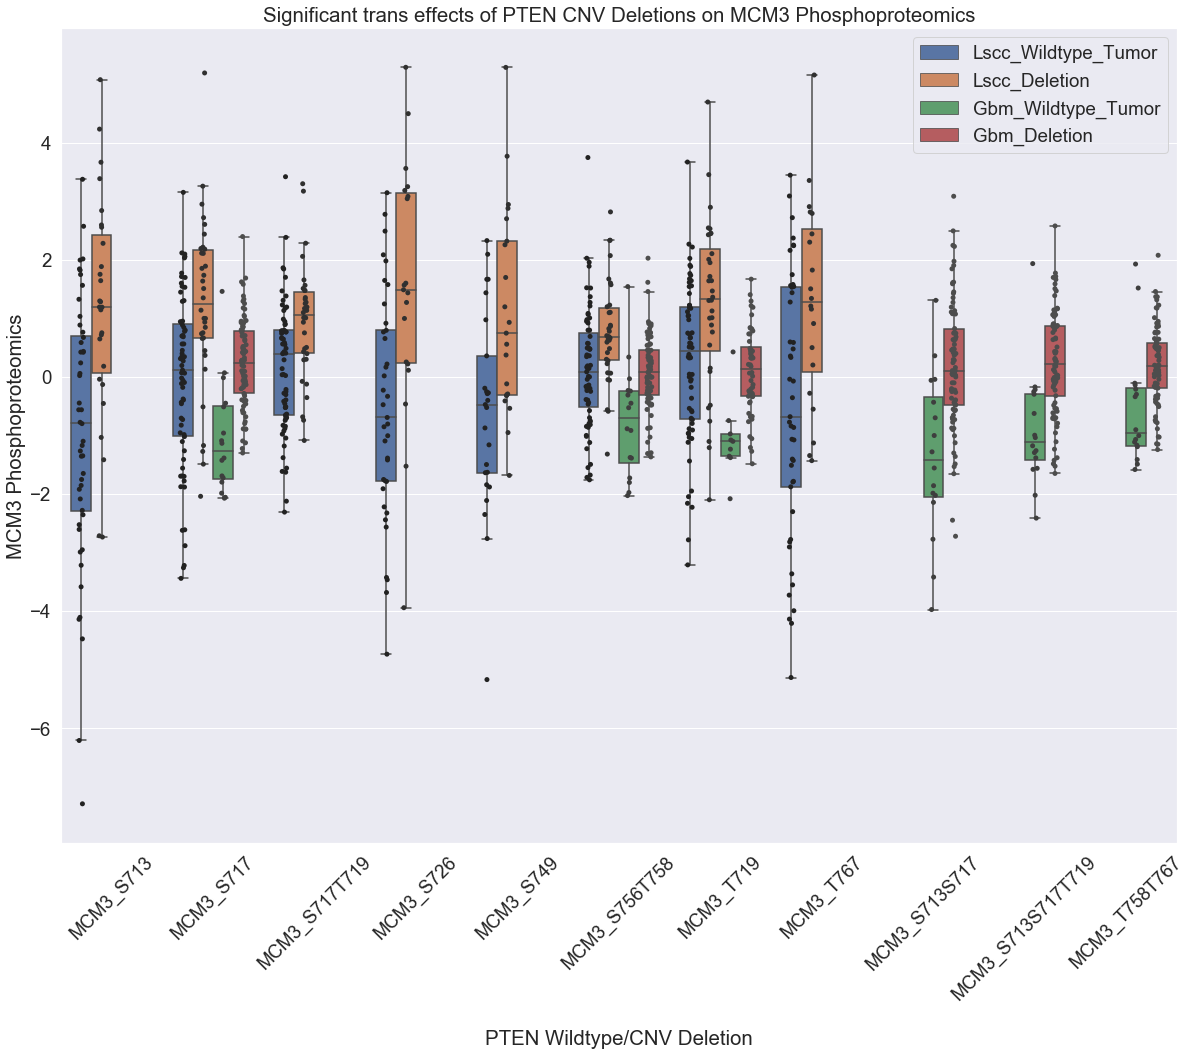

In [86]:
gene = 'PTEN'
plt.rcParams['figure.figsize']=(20,15) #size of plot
sns.set(font_scale = 1.7)

boxplot = sns.boxplot(x='Site', y='Omics', data = sig_phos, hue = 'Mutation',
                      hue_order = ["Lscc_Wildtype_Tumor", "Lscc_Deletion", 'Gbm_Wildtype_Tumor', 'Gbm_Deletion'],
                      showfliers = False)    
boxplot.set_title('Significant trans effects of PTEN CNV Deletions on '+t_gene+' Phosphoproteomics')
boxplot = sns.stripplot(x='Site', y='Omics', data = sig_phos, jitter = True, 
                           color = ".3", hue = 'Mutation',dodge = True, 
                        hue_order = ["Lscc_Wildtype_Tumor", "Lscc_Deletion", 'Gbm_Wildtype_Tumor', 'Gbm_Deletion'])
boxplot.set(xlabel = "\n"+gene+" Wildtype/CNV Deletion", ylabel = t_gene+' Phosphoproteomics')

boxplot.set_xticklabels(boxplot.get_xticklabels(), rotation=45)


# format legend
handles, labels = boxplot.get_legend_handles_labels()
plt.legend(handles[0:4], labels[0:4])


# Create significance symbols:
# * P ≤ 0.05   ** P ≤ 0.01   *** P ≤ 0.001 
'''
format_pval_annotation("**", -.3, -.1, 4.3) 
format_pval_annotation("***", .1, .3, 3) 
format_pval_annotation("***", .7, .9, 3.5) 
format_pval_annotation("***", 1.7, 1.9, 4) 
format_pval_annotation("**", 3.1, 3.3, 2.1) 
'''

plt.show()
plt.clf()
plt.close()

In [87]:
ls_pval

,Comparison,P_Value
0,MCM3_phosphoproteomics_S717_SEDEsETEDEEEK,0.000059
1,MCM3_phosphoproteomics_S713_KRsEDESETEDEEEK,0.000131
2,MCM3_phosphoproteomics_S717T719_SEDEsEtEDEEEK,0.000558
3,MCM3_phosphoproteomics_S726_RSEDESETEDEEEKsQED...,0.000678
4,MCM3_phosphoproteomics_T719_RSEDESEtEDEEEK,0.001646
5,MCM3_phosphoproteomics_S756T758_DGDSYDPYDFsDtE...,0.001785
6,MCM3_phosphoproteomics_S749_DGDsYDPYDFSDTEEEMP...,0.002089
7,MCM3_phosphoproteomics_T767_DGDSYDPYDFSDTEEEMP...,0.002215


In [88]:
g_pval

,Comparison,P_Value
0,MCM3_phosphoproteomics_S717_RSEDES*ETEDEEEK,4.715054e-08
1,MCM3_phosphoproteomics_S713S717_KRS*EDES*ETEDEEEK,3.917191e-06
2,MCM3_phosphoproteomics_S713S717T719_KRS*EDES*E...,1.248490e-05
3,MCM3_phosphoproteomics_S756T758_DGDSYDPYDFS*DT...,2.452556e-05
4,MCM3_phosphoproteomics_T719_RSEDESET*EDEEEK,3.921622e-05
5,MCM3_phosphoproteomics_T758T767_DGDSYDPYDFSDT*...,4.333848e-04


In [ ]:
# Save figure
#fig = boxplot.get_figure()
#fig.savefig(".png")